In [ ]:
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [ ]:
import sys
custom_modules = [mod for mod in sys.modules if mod.startswith('utils.') or mod.startswith('neuronModels.')]
for module in custom_modules:
    del sys.modules[module]
from neuronModels.fitzhughNagumo_model import fitzhughNagumo_model
from neuronModels.GRUNetwork import GRUNetwork
from neuronModels.HybridModel import HybridModel
from neuronModels.IzhikevichModel import izhikevich_model
from utils.DataHandler import DataHandler
from utils.Plotter import Plotter
from utils.Logger import Logger, LogLevel
from utils.Constants import Constants

logger = Logger()
logger.log("Librerie Buildate", LogLevel.INFO)

[2025-03-14 22:33:31] [INFO] Custom message


Dati di banchmark articolo [1]:


In [ ]:

# Calculate adjacency matrix G using Kronecker product
G = DataHandler.generate_adjacency_matrix(Constants.A1, n=3)

[2025-03-14 22:38:03] [INFO] LGenerated synthetic data for FitzHugh-Nagumo model


In [ ]:
# FitzHugh-Nagumo Model
hybrid_model = HybridModel()
fn_model = fitzhughNagumo_model(Constants.N, Constants.EPSILON, Constants.SIGMA, Constants.A, Constants.B, G)

t,sol = fn_model._generate_synthetic_data()
logger.log("LGenerated synthetic data for FitzHugh-Nagumo model")

[LOG] Generated synthetic data for FitzHugh-Nagumo model


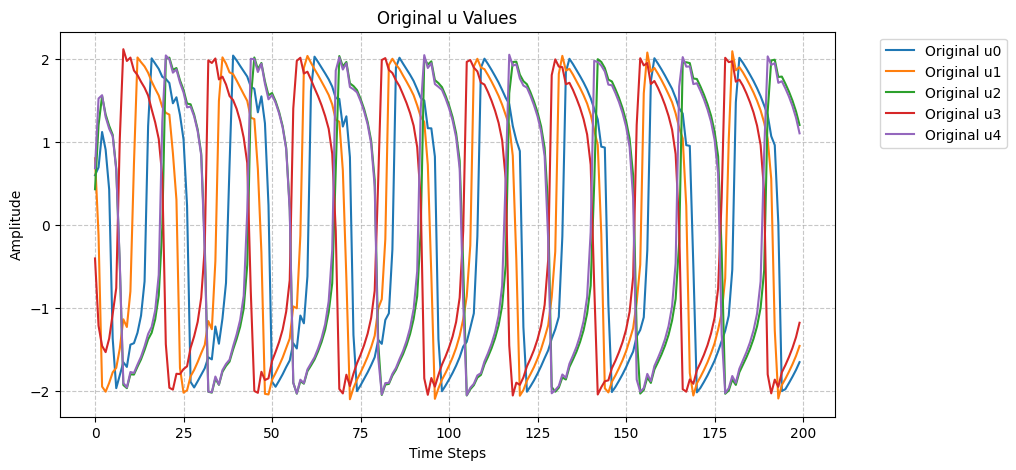

Test


In [ ]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(sol[:200,i], label=f'Original u{i}')
       
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_original_u_values(sol, num_neurons = 1)

In [61]:

x,y = hybrid_model._prepare_data(sol)
x_train, y_train, x_test, y_test = hybrid_model._split_train_test(x,y)

In [62]:

model = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 200 )
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)


Epoch [20/200], Train Loss: 0.0664 
Epoch [40/200], Train Loss: 0.0354 
Epoch [60/200], Train Loss: 0.0258 
Epoch [80/200], Train Loss: 0.0183 
Epoch [100/200], Train Loss: 0.0130 
Epoch [120/200], Train Loss: 0.0106 
Epoch [140/200], Train Loss: 0.0088 
Epoch [160/200], Train Loss: 0.0076 
Epoch [180/200], Train Loss: 0.0067 
Epoch [200/200], Train Loss: 0.0058 


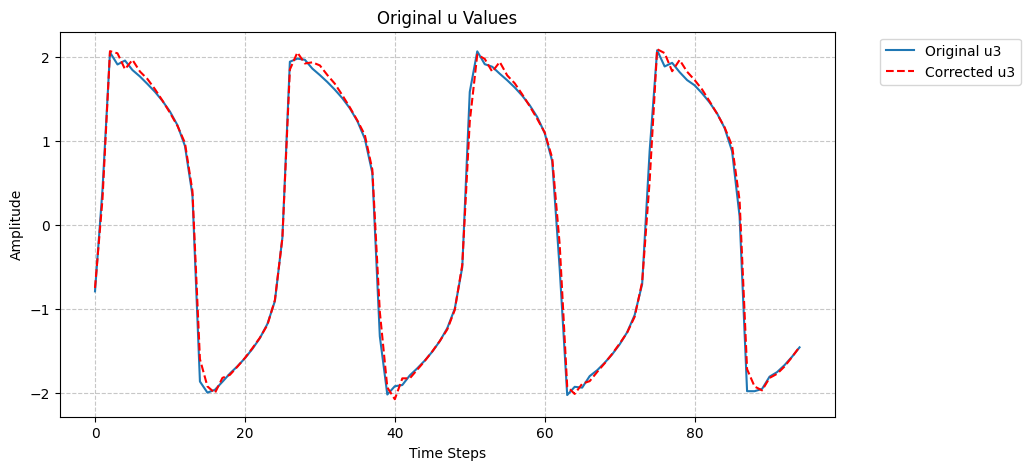

In [64]:
#sol = hybrid_model._standardize(sol)
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 3], label=f'Original u{i}')
        plt.plot(forecasted[:200,3], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_comparison(
    y_test=y_test,
    forecasted=forecasted,
    index=3,
    time_steps=200,
    var_name='u',
    title='Original u Values'
)


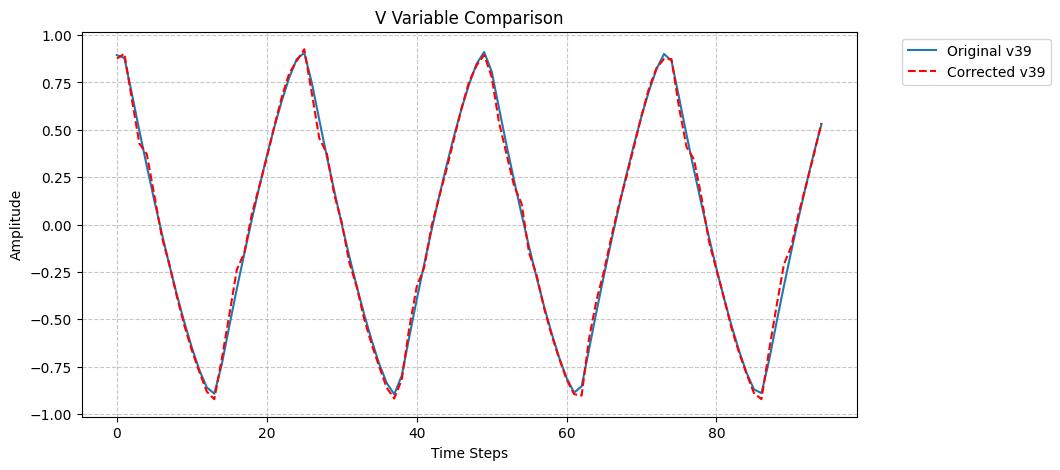

In [ ]:
Plotter.plot_comparison(y_test, forecasted, index=39, var_name='v', 
                       time_steps=95, title='V Variable Comparison')


In [66]:
x_error, y_error = hybrid_model.create_error_sequences(model_data = sol , true_data = sol)
model_corrections = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model_corrections.parameters(), lr=0.001)
trained_model_corrections = hybrid_model._train(model_corrections,x_error,y_error,optimizer,epochs = 200 )
forecast = hybrid_model._forecast(trained_model_corrections, x_test, y_test, corrections=True)

Epoch [20/200], Train Loss: 0.0002 
Epoch [40/200], Train Loss: 0.0000 
Epoch [60/200], Train Loss: 0.0000 
Epoch [80/200], Train Loss: 0.0000 
Epoch [100/200], Train Loss: 0.0000 
Epoch [120/200], Train Loss: 0.0000 
Epoch [140/200], Train Loss: 0.0000 
Epoch [160/200], Train Loss: 0.0000 
Epoch [180/200], Train Loss: 0.0000 
Epoch [200/200], Train Loss: 0.0000 


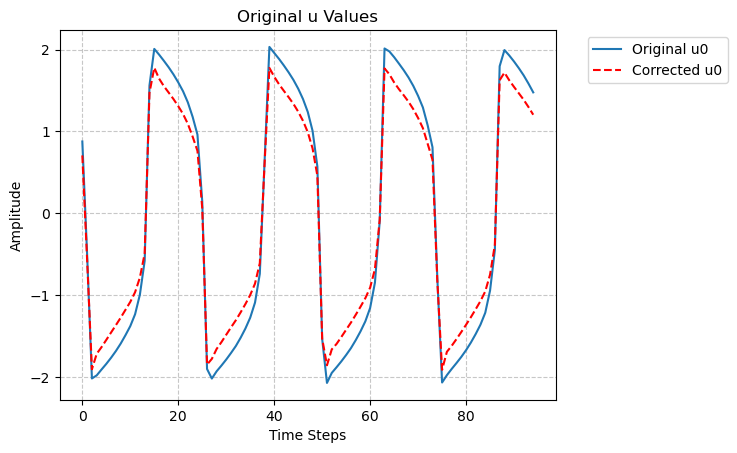

In [ ]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 2], label=f'Original u{i}')
        plt.plot(forecast[:200,2], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_comparison(
    y_test=y_test,
    forecasted=forecast,
    index=2,  # since you were using index 2 in the original code
    time_steps=200,
    var_name='u',
    title='Original u Values'
)

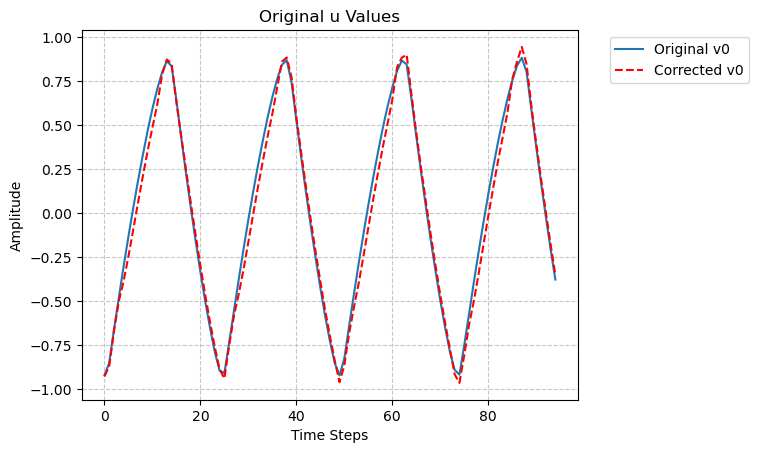

In [ ]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 26], label=f'Original v{i}')
        plt.plot(forecast[:200,26], label=f'Corrected v{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_comparison(
    y_test=y_test,
    forecasted=forecast,
    index=26,
    time_steps=200,
    var_name='v',  # Note: changed to 'v' since this plots v variable
    title='Original v Values'  # Also updated title to reflect v variable
)

PEZZO DA CONTROLLARE + classe IZHIKEVIC

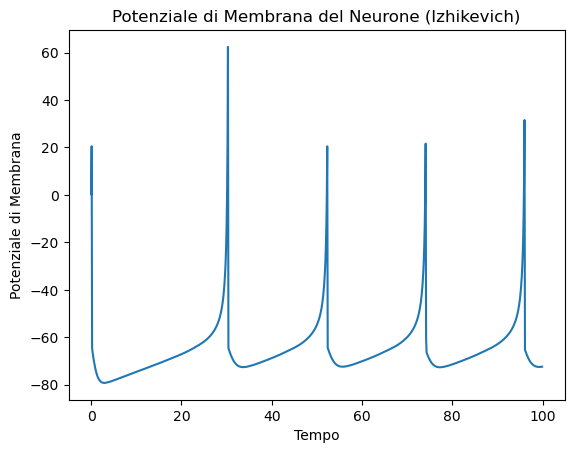

In [28]:


izh_model = izhikevich_model(N=20, a=0.05, b=0.2, c=-65, d=8, I=10)
t, data = izh_model._generate_synthetic_data(T=100, dt=0.1)
hybrid_model = HybridModel()

plt.plot(t, data[:, 1])  
plt.title("Potenziale di Membrana del Neurone (Izhikevich)")
plt.xlabel("Tempo")
plt.ylabel("Potenziale di Membrana")
plt.show()

In [30]:

x,y = hybrid_model._prepare_data(data)
x_train, y_train, x_test, y_test = hybrid_model._split_train_test(x,y)

In [ ]:
model = hybrid_model._create_gru(len(data[1]),len(data[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.1)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 1000 )

Epoch [20/1000], Train Loss: 71.1221 
Epoch [40/1000], Train Loss: 77.4745 
Epoch [60/1000], Train Loss: 69.9844 
Epoch [80/1000], Train Loss: 67.9525 
Epoch [100/1000], Train Loss: 66.1560 
Epoch [120/1000], Train Loss: 64.6790 
Epoch [140/1000], Train Loss: 63.2730 
Epoch [160/1000], Train Loss: 63.0206 


KeyboardInterrupt: 

In [45]:
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)

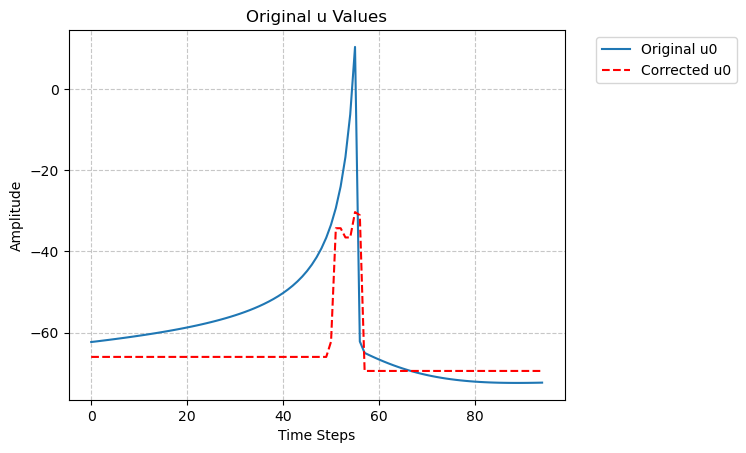

In [ ]:
#sol = hybrid_model._standardize(sol)
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:, 5], label=f'Original u{i}')
        plt.plot(forecasted[:,5], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_comparison(
    y_test=y_test,
    forecasted=forecasted,
    index=5,
    time_steps=y_test.shape[0],  # Using full length since no slice was specified
    var_name='u',
    title='Original u Values'
)
